# Train autoformers on randomized data

To check the extent to which autoformers memorize the data instead of learning actually interesting representations, I train the autoformer model on data with randomized forecasts, to see how training looks like, and whether it even takes longer than the correct forecasts.

In [2]:
import sys

sys.path.append("..")
sys.path.append("../..")
import activations_interpretations.data_utils as data_utils
import analysis.activations_interpretations.CKA as CKA
import analysis.activations_interpretations.activations as activations_file

from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

import pandas as pd
import os
from utils.timefeatures import time_features

from typing import List

from pandas.tseries.frequencies import to_offset
from pandas.tseries import offsets
import numpy as np


class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex, offset=0) -> np.ndarray:
        return (index.hour + offset) % 24 / 23.0 - 0.5

    def inverse(input: np.ndarray) -> np.ndarray:
        return (input + 0.5) * 23.0


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex, offset=0) -> np.ndarray:
        return (index.dayofweek + offset) % 7 / 6.0 - 0.5

    def inverse(input: np.ndarray) -> np.ndarray:
        return (input + 0.5) * 6.0


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex, offset=0) -> np.ndarray:
        return (index.day - 1 + offset) % 31 / 30.0 - 0.5

    def inverse(input: np.ndarray) -> np.ndarray:
        return (input + 0.5) * 30.0 + 1


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex, offset=0) -> np.ndarray:
        return (index.dayofyear - 1 + offset) % 366 / 365.0 - 0.5

    def inverse(input: np.ndarray) -> np.ndarray:
        return (input + 0.5) * 365.0 + 1


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(
    dates,
    freq="h",
    HourOfDay_offset=0,
    DayOfWeek_offset=0,
    DayOfMonth_offset=0,
    DayOfYear_offset=0,
):
    func = [HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear()]
    output = []
    for feat in func:
        if isinstance(feat, HourOfDay):
            output.append(feat(dates, HourOfDay_offset))
        elif isinstance(feat, DayOfWeek):
            output.append(feat(dates, DayOfWeek_offset))
        elif isinstance(feat, DayOfMonth):
            output.append(feat(dates, DayOfMonth_offset))
        elif isinstance(feat, DayOfYear):
            output.append(feat(dates, DayOfYear_offset))

    return np.vstack(output)

In [3]:
class Dataset_Custom(Dataset):
    def __init__(
        self,
        root_path,
        flag="train",
        size=None,
        features="S",
        data_path="ETTh1.csv",
        target="OT",
        scale=True,
        timeenc=0,
        freq="h",
        HourOfDay_offset=0,
        DayOfWeek_offset=0,
        DayOfMonth_offset=0,
        DayOfYear_offset=0,
    ):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ["train", "test", "val"]
        type_map = {"train": 0, "val": 1, "test": 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.HourOfDay_offset = HourOfDay_offset
        self.DayOfWeek_offset = DayOfWeek_offset
        self.DayOfMonth_offset = DayOfMonth_offset
        self.DayOfYear_offset = DayOfYear_offset

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path, self.data_path))

        """
        df_raw.columns: ['date', ...(other features), target feature]
        """
        cols = list(df_raw.columns)
        cols.remove(self.target)
        cols.remove("date")
        df_raw = df_raw[["date"] + cols + [self.target]]
        # print(cols)
        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == "M" or self.features == "MS":
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == "S":
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0] : border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[["date"]][border1:border2]
        df_stamp["date"] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp["month"] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp["day"] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp["weekday"] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp["hour"] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(["date"], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(
                pd.to_datetime(df_stamp["date"].values),
                freq=self.freq,
                HourOfDay_offset=self.HourOfDay_offset,
                DayOfWeek_offset=self.DayOfWeek_offset,
                DayOfMonth_offset=self.DayOfMonth_offset,
                DayOfYear_offset=self.DayOfYear_offset,
            )
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [6]:
data_loader = data_utils.obtain_data_loader(pred_len=96, dataset="electricity")
autoformer = data_utils.obtain_autoformer(pred_len=96, dataset="ECL")

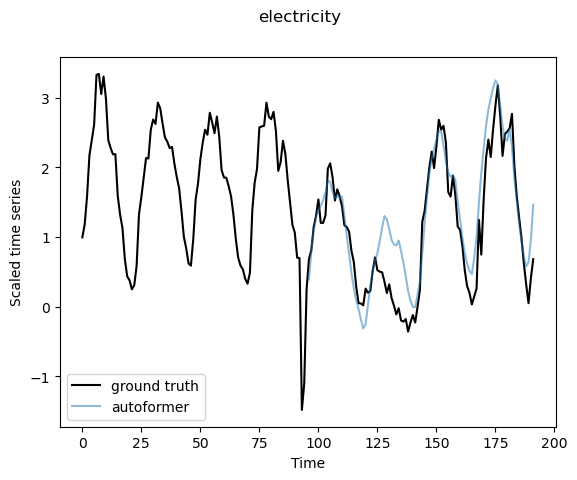

In [8]:
data_utils.obtain_plot_predictions(
    pred_len=96,
    data_set="electricity",
    data_loader=data_loader,
    model=autoformer,
)

torch.Size([1, 144, 321])


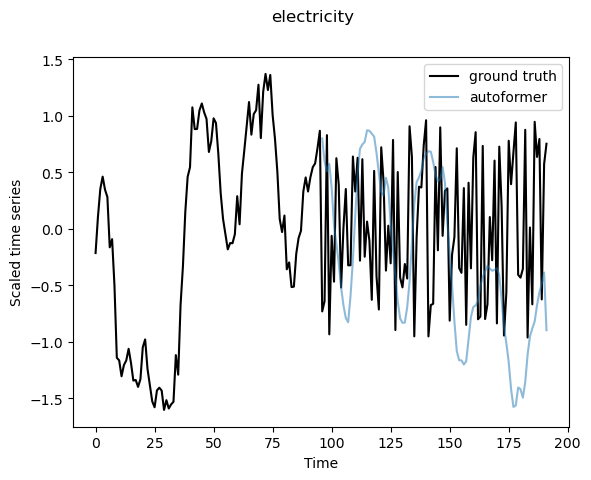

In [14]:
import torch
import matplotlib.pyplot as plt

pred_len = 96
label_len = 48
alpha_gt = 1
alpha_pred = 0.5

with torch.no_grad():
    for i, (seq_x, seq_y, seq_x_mark, seq_y_mark) in enumerate(data_loader):
        # seq_x is batch_size x seq_len x N_timeseries
        # seq_y is batch_size x label_len x N_timeseries
        # seq_x_mark is batch_size x seq_len X N_timefeatures
        # seq_y_mark is batch_size x (label_len+pred_len) X N_timefeatures

        print(seq_y.shape)

        seq_y = torch.rand(seq_y.shape) * 2 - 1  # random values between -1 and 1

        # decoder input
        dec_inp = torch.zeros_like(seq_y[:, -pred_len:, :]).float()
        dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()

        # gt = np.concatenate((seq_x[0, :, 0], seq_y[0, -pred_len:, 0]), axis=0)
        gt = np.concatenate((seq_x[0, :, -1], seq_y[0, -pred_len:, -1]), axis=0)

        outputs_autoformer, _ = autoformer(
            seq_x.float(), seq_x_mark.float(), dec_inp, seq_y_mark.float()
        )
        pd_autoformer = np.concatenate(
            (
                [np.nan for i in range(seq_x.shape[1])],
                outputs_autoformer[0, -pred_len:, -1],
            ),
            axis=0,
        )

        plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
        plt.plot(pd_autoformer, label="autoformer", alpha=alpha_pred)

        # for vline in vlines:
        #     plt.axvline(x=vline, color="b", linestyle="--")

        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Scaled time series")
        plt.suptitle("electricity")

        # if timestamps:
        #     time_feat = data_utils.time_features_from_frequency_str_uncalled("h")
        #     x_timestamps = data_utils.obtain_timestamps(seq_x_mark, time_feat)
        #     y_timestamps = data_utils.obtain_timestamps(seq_y_mark, time_feat)[-pred_len:]
        #     timestamps = x_timestamps + y_timestamps

        #     tick_positions = [
        #         i
        #         for i, tick_label in enumerate(timestamps)
        #         if tick_label.startswith("0H")
        #     ]
        #     tick_labels = [timestamps[i][3:] for i in tick_positions]
        #     plt.xticks(tick_positions, tick_labels, rotation=45)
        #     plt.grid(True)

        plt.show()

        break